1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [43]:
import numpy as np
from scipy import linalg as la
N=1000
x1= np.random.normal(0, 1, N)
x2=x1+np.random.normal(0, 3, N)
x3= 2*x1+x2
data=np.array([x1,x2, x3])
cov=np.cov(data, rowvar=True)

print(cov, "\n")
l, V = la.eig(cov)
l=np.real_if_close(l)

print(l, "\n")
print(V, "\n")


[[ 0.92117429  1.11850912  2.96085769]
 [ 1.11850912  9.74292072 11.97993896]
 [ 2.96085769 11.97993896 17.90165435]] 

[2.68390412e+01 6.99626074e-18 1.72670820e+00] 

[[-0.11731307 -0.81649658  0.56530609]
 [-0.57504266 -0.40824829 -0.70898467]
 [-0.80966881  0.40824829  0.42162751]] 



In [44]:
U, S, V = np.linalg.svd(cov)
print(np.sort(S),"\n")
print(U)

#the smallest eigenvalue is in disagreement

[1.95338115e-15 1.72670820e+00 2.68390412e+01] 

[[-0.11731307  0.56530609 -0.81649658]
 [-0.57504266 -0.70898467 -0.40824829]
 [-0.80966881  0.42162751  0.40824829]]


In [45]:
print("Explanation by feature:")
print (np.sort(np.real_if_close(l))/np.trace(cov)*100)
#as expected one feature doesn't explain the data set since it is only given by 
#a linear combination of the other features 

#reduce dimensionality
x=l>1

reduced_data= [(data.T[i])[x] for i in range(len(data.T))]

Explanation by feature:
[2.44917809e-17 6.04468021e+00 9.39553198e+01]


In [46]:
#rotated data
data_newbase=np.array([np.dot(V,data.T[i]) for i in range(len(data.T))]).T


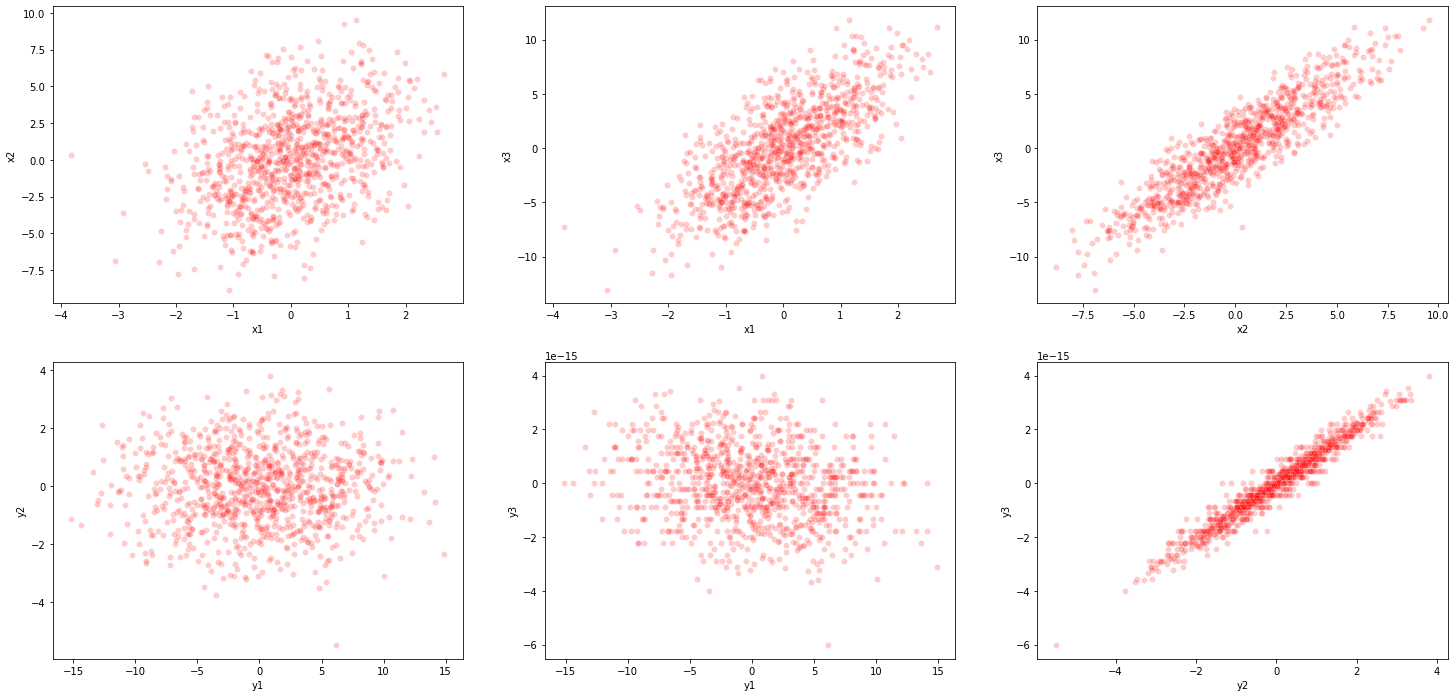

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(nrows=2 , ncols=3, figsize=(25,12))
c = 'red'

sns.scatterplot(x=x1, y=x2, ax=ax[0,0], color=c, alpha=0.2)
ax[0,0].set_xlabel('x1')
ax[0,0].set_ylabel('x2')

sns.scatterplot(x=x1, y=x3, ax=ax[0,1], color=c, alpha=0.2)
ax[0,1].set_xlabel('x1')
ax[0,1].set_ylabel('x3')


sns.scatterplot(x=x2, y=x3, ax=ax[0,2], color=c, alpha=0.2)
ax[0,2].set_xlabel('x2')
ax[0,2].set_ylabel('x3')


sns.scatterplot(x=data_newbase[0], y=data_newbase[1], ax=ax[1,0], color=c, alpha=0.2)
ax[1,0].set_xlabel('y1')
ax[1,0].set_ylabel('y2')

sns.scatterplot(x=data_newbase[0], y=data_newbase[2], ax=ax[1,1], color=c, alpha=0.2)
ax[1,1].set_xlabel('y1')
ax[1,1].set_ylabel('y3')


sns.scatterplot(x=data_newbase[1], y=data_newbase[2], ax=ax[1,2], color=c, alpha=0.2)
ax[1,2].set_xlabel('y2')
ax[1,2].set_ylabel('y3')

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [54]:
x=[np.random.normal(0,1/50,size=N) for i in range(10)]
data=np.concatenate((data, x))
cov=np.cov(data)
U, S, V = np.linalg.svd(cov)
print("eigenvalues:",np.sort(S),"\n")
print("Explanation by feature:")
print (np.sort(np.real_if_close(S))/np.trace(cov)*100)

eigenvalues: [1.74614628e-14 2.87284476e-04 2.92222449e-04 3.10333037e-04
 3.21309386e-04 3.24061129e-04 3.33574708e-04 3.34818564e-04
 3.43266604e-04 3.47956253e-04 3.59247198e-04 3.68144508e-04
 3.72575894e-04 3.78464633e-04 3.89858109e-04 3.92975834e-04
 3.99803897e-04 4.03526730e-04 4.05324777e-04 4.18125368e-04
 4.22870145e-04 4.35707801e-04 4.41657581e-04 4.47594147e-04
 4.64236082e-04 4.71571519e-04 4.73578185e-04 4.97372384e-04
 5.10781585e-04 5.17092921e-04 5.33180990e-04 1.72672207e+00
 2.68390541e+01] 

Explanation by feature:
[6.11015483e-14 1.00527238e-03 1.02255145e-03 1.08592443e-03
 1.12433312e-03 1.13396208e-03 1.16725221e-03 1.17160474e-03
 1.20116632e-03 1.21757644e-03 1.25708598e-03 1.28821964e-03
 1.30372605e-03 1.32433206e-03 1.36420037e-03 1.37510999e-03
 1.39900290e-03 1.41202992e-03 1.41832169e-03 1.46311381e-03
 1.47971684e-03 1.52463866e-03 1.54545826e-03 1.56623163e-03
 1.62446547e-03 1.65013380e-03 1.65715557e-03 1.74041677e-03
 1.78733855e-03 1.80942332e-0

So we see that not much as changed from the previous case since the information brought by the new features is not relevant and we understand this by noting that the features that explained 99% of the data in the previous case, still explain the 99%.